**HR-аналитика**

**Задачи:**

1. Предсказать уровнь удовлетворённости сотрудника;
2. Предсказать увольнение сотрудника из компании.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
import seaborn as sns
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

from sklearn.svm import SVC, SVR
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    PolynomialFeatures
)

from sklearn.metrics import ( 
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer
)

import xgboost as xgb

import warnings
from imblearn.combine import SMOTETomek
import shap

try:
    import phik 
    from phik import phik_matrix
    from phik.report import plot_correlation_matrix

except:
    !pip install phik


# вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# отключаем предупреждение
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

**Задача 1: предсказание уровня удовлетворённости сотрудника**

# Загрузка данных

Загрузим файлы с данными

Тренировочная выборка:
- train_job_satisfaction_rate.csv
  
Входные признаки тестовой выборки:
- test_features.csv

Целевой признак тестовой выборки:
- test_target_job_satisfaction_rate.csv

In [ ]:
try:
    train_job_satisfaction_rate = pd.read_csv(
        r'...\train_job_satisfaction_rate.csv')
    test_features = pd.read_csv(
        r'...\test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv(
        r'...\test_target_job_satisfaction_rate.csv')
    
except:
    train_job_satisfaction_rate = pd.read_csv('.../train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('.../test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('.../test_target_job_satisfaction_rate.csv')

## Выведем первые строки каждого набора данных

In [4]:
display(train_job_satisfaction_rate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
display(test_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
display(test_target_job_satisfaction_rate.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


# Предобработка данных

Изучим данные и сделаем выводы

Подготовка данных для анализа называется предобработкой. Нужно оценить масштаб найденных проблем и устранить их. Предобработка следует принципу GIGO (от англ. garbage in — garbage out, буквально «мусор на входе — мусор на выходе»). Это значит, что при ошибках во входных данных даже правильный алгоритм работы приведёт к неверным результатам. Так же нужно помнить об законе экономии, который называется Бри́тва О́ккама. В нем говорится следующее: Не следует множить сущее без необходимости. Суть принципа: совершенство должно быть простым. Если какого-то результата можно достичь с привлечением сущностей A, B и C либо другим путём с привлечением A, B, С и D — надо выбирать первый путь. В плане программирования это значит, что не следут создавать промежуточные переменные, которые не пригодяться в дальнейшем.

## Проверка данных на соответствие техническому описанию

Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [7]:
# проверим дубликаты
train_job_satisfaction_rate[train_job_satisfaction_rate['id'].duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


In [8]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [9]:
display(train_job_satisfaction_rate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [11]:
display(test_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [12]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [13]:
display(test_target_job_satisfaction_rate.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Все таблицы соответствуют техническому описанию. В столбцах **dept, level** датафреймов train_job_satisfaction_rate 
и test_features есть пропуски, заполним их с помощью пайплайна в разделе подготовки данных.

In [14]:
test_features.dept.unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Присутствует полностью случайный пропуск, заменим на `NaN`

In [15]:
test_features = test_features.replace(' ', np.nan)

# Исследовательский анализ данных

Исследуем все признаки и сделаем выводы о том, как их нужно подготовить. Исследовательский анализ данных 
является важным этапом в аналитике, который позволяет лучше понять данные и выявить основные характеристики и закономерности. Опишем и визуализируем общую информацию о пользователях и поездках.

В представленных данных есть следующие признаки: целевые (прогнозируемые) и входные (прогнозирующие) признаки.

Целевой количественный:
- job_satisfaction_rate.

Входной количественный:
- salary,

категиальные:
- dept,
- level,
- workload,
- last_year_promo,
- last_year_violations,
- employment_years,
- supervisor_evaluation.

## Статистический анализ признаков

### Тренировочная выборка

In [16]:
# входные признаки
(
    train_job_satisfaction_rate
    .select_dtypes(include='number')
    .drop(['id', 'employment_years', 'supervisor_evaluation'], axis=1)
    .describe()
    .style.format('{:,.2f}')
)

,salary,job_satisfaction_rate
count,"4,000.00","4,000.00"
mean,"33,926.70",0.53
std,"14,900.70",0.23
min,"12,000.00",0.03
25%,"22,800.00",0.36
50%,"30,000.00",0.56
75%,"43,200.00",0.71
max,"98,400.00",1.00


Значения выглядят адекватно

### Тестовая выборка

In [17]:
# входные признаки
(
    test_features
    .select_dtypes(include='number')
    .drop(['id', 'employment_years', 'supervisor_evaluation'], axis=1)
    .describe()
    .style.format('{:,.2f}')
)

,salary
count,"2,000.00"
mean,"34,066.80"
std,"15,398.44"
min,"12,000.00"
25%,"22,800.00"
50%,"30,000.00"
75%,"43,200.00"
max,"96,000.00"


Значения выглядят адекватно

In [18]:
# целевой признак
(
    test_target_job_satisfaction_rate
    .select_dtypes(include='number')
    .drop('id', axis=1)
    .describe()
    .style.format('{:,.2f}')
)

,job_satisfaction_rate
count,"2,000.00"
mean,0.55
std,0.22
min,0.03
25%,0.38
50%,0.58
75%,0.72
max,1.00


Значения выглядят адекватно и без аномалий 

## График количиственных признаков

In [19]:
# собственная функция с случайным цветом
def hist_box_num_sub(categ, data, x, title_hist, xlabel, ylabel):

    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = categ

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}
    colors_box = {cat: random_color() for cat in categories}

    # инициализация объекта fig и создание подграфиков
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # гистограмма
    sns.histplot(
        data=data, 
        x=x, 
        hue='level',
        palette=colors_hist,
        ax=axes[0], 
        kde=True,
        multiple='stack'
        )
    axes[0].set_title(title_hist,  fontsize=9)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    # boxplot
    sns.boxplot(
        data=data, 
        x=x, 
        hue='level',
        palette=colors_box,
        ax=axes[1]
        )
    axes[1].set_title('Ящик с усами колическтвенного признака',  fontsize=9)
    axes[1].set_xlabel(xlabel)
    axes[1].legend(title='level', loc='upper left')

    plt.tight_layout()
    plt.show()

### Тренировочная выборка

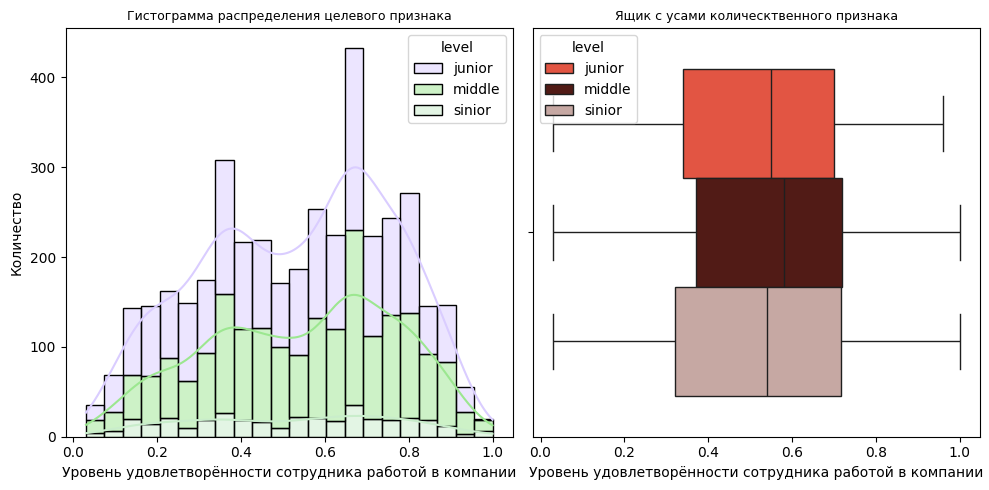

In [20]:
# целевой признак
hist_box_num_sub(
    train_job_satisfaction_rate.level.unique(),
    train_job_satisfaction_rate, 
    'job_satisfaction_rate', 
    'Гистограмма распределения целевого признака', 
    'Уровень удовлетворённости сотрудника работой в компании', 
    'Количество'
)

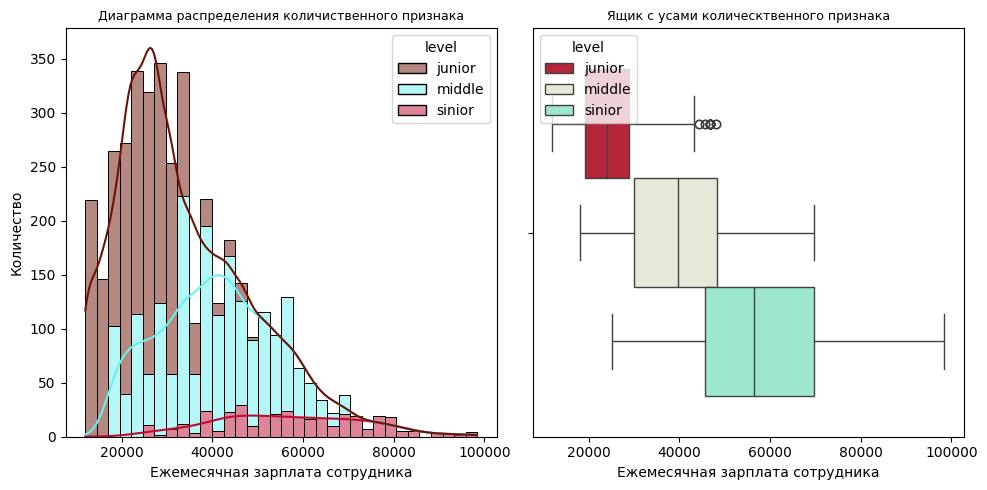

In [21]:
# salary
hist_box_num_sub(
    train_job_satisfaction_rate.level.unique(),
    train_job_satisfaction_rate, 
    'salary', 
    'Диаграмма распределения количиственного признака', 
    'Ежемесячная зарплата сотрудника', 
    'Количество'
)

### Тестовая выборка

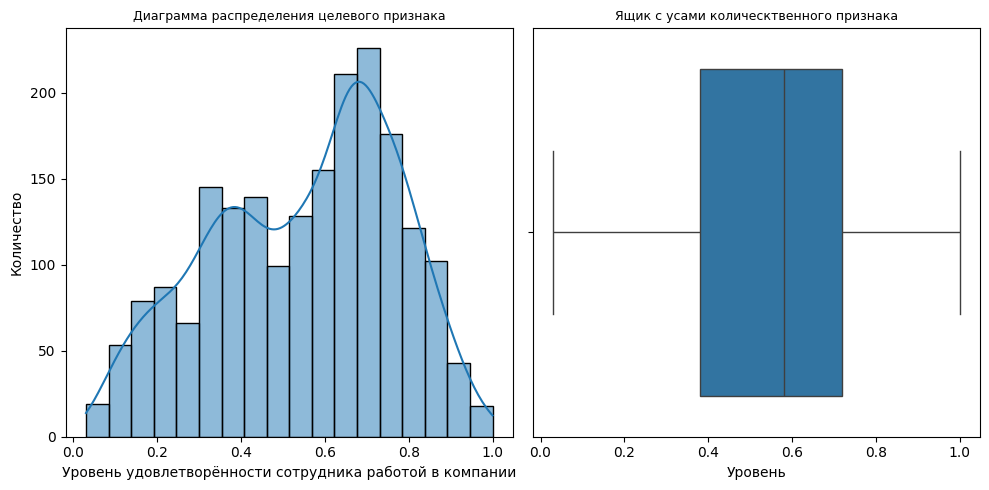

In [22]:
# целевой признак
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
# гистограмма
sns.histplot(
    test_target_job_satisfaction_rate,
    x='job_satisfaction_rate',
    ax=axes[0],
    kde=True,
    multiple='stack'
)
axes[0].set_title('Диаграмма распределения целевого признака',  fontsize=9)
axes[0].set_xlabel('Уровень удовлетворённости сотрудника работой в компании')
axes[0].set_ylabel('Количество')
    
sns.boxplot(
    test_target_job_satisfaction_rate,
    x='job_satisfaction_rate', 
    ax=axes[1]
)
axes[1].set_title('Ящик с усами колическтвенного признака',  fontsize=9)
axes[1].set_xlabel('Уровень')

plt.tight_layout()
plt.show()

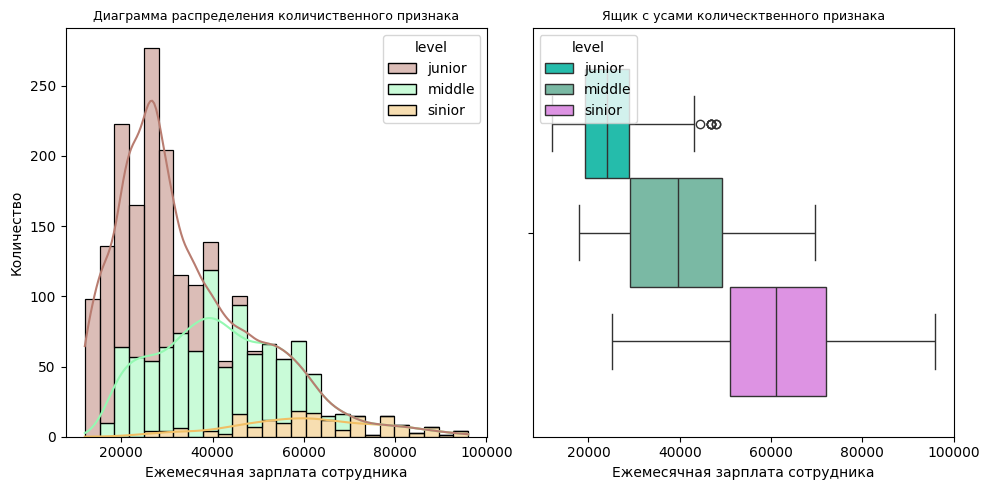

In [23]:
# salary
hist_box_num_sub(
    test_features.level.unique(),
    test_features, 
    'salary', 
    'Диаграмма распределения количиственного признака', 
    'Ежемесячная зарплата сотрудника', 
    'Количество'
)

## Графики категориальных признаков

In [24]:
# собственная функция с случайным цветом
def hist_countolot(data, x, xlabel):

    # создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # уникальные категории
    categories = data.level.unique()

    # случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}

    # гистограмма
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(
        data,
        x=x, 
        palette=colors_hist,
        hue='level', 
        stat='percent'
    )
    ax.set_title('График распределения категориального признака',  fontsize=9)

    
    # настраиваем ось Y для отображения целых чисел
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.xlabel(xlabel)
    plt.ylabel('Количество сотрудников')
    plt.legend(title='Уровень занимаемой должности', loc='upper right')
    plt.show()

### Тренировочная выборка

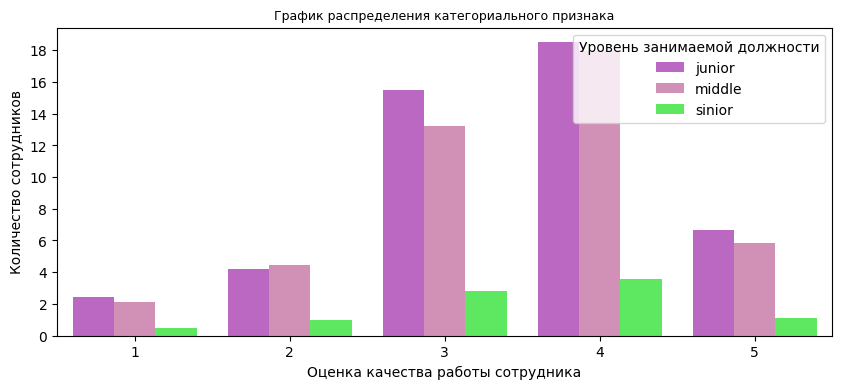

In [25]:
# supervisor_evaluation
hist_countolot(
    train_job_satisfaction_rate, 
    'supervisor_evaluation', 
    'Оценка качества работы сотрудника'
) 

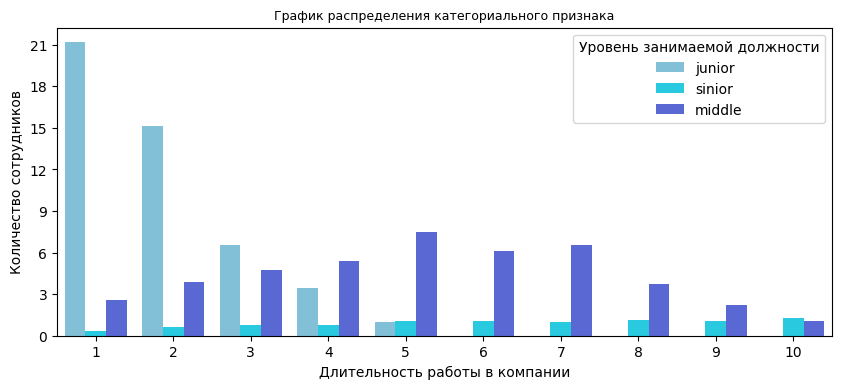

In [26]:
# employment_years
hist_countolot(
    train_job_satisfaction_rate, 
    'employment_years', 
    'Длительность работы в компании'
) 

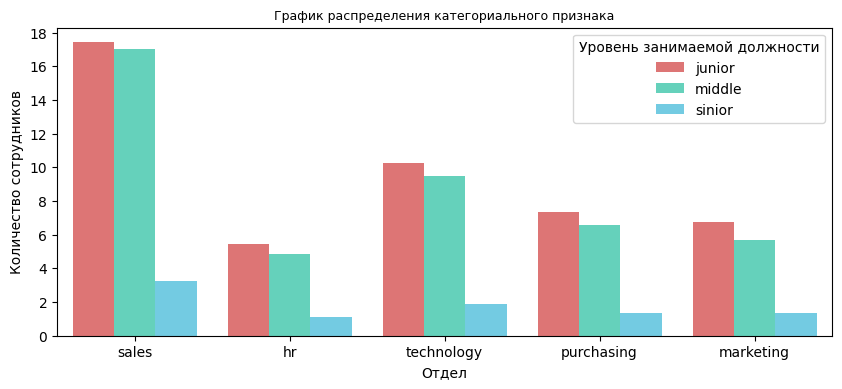

In [27]:
# dept
hist_countolot(
    train_job_satisfaction_rate, 
    'dept', 
    'Отдел'
) 

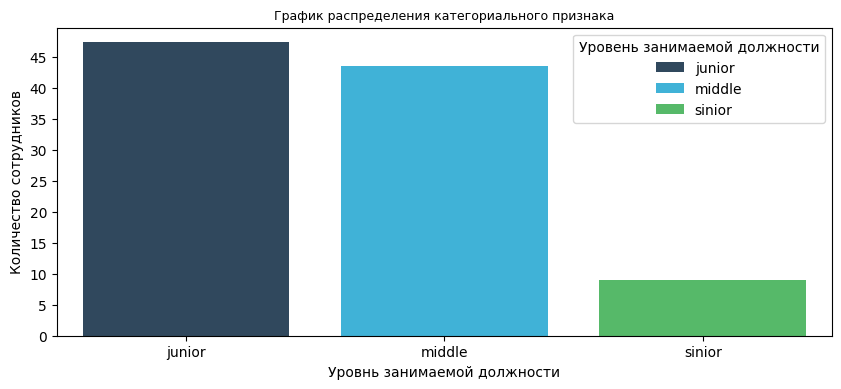

In [28]:
# level
hist_countolot(
    train_job_satisfaction_rate, 
    'level', 
    'Уровнь занимаемой должности'
)

Данный признак нужно будет обработать OrdinalEncoder, потому что присутствуют ранговые категории.

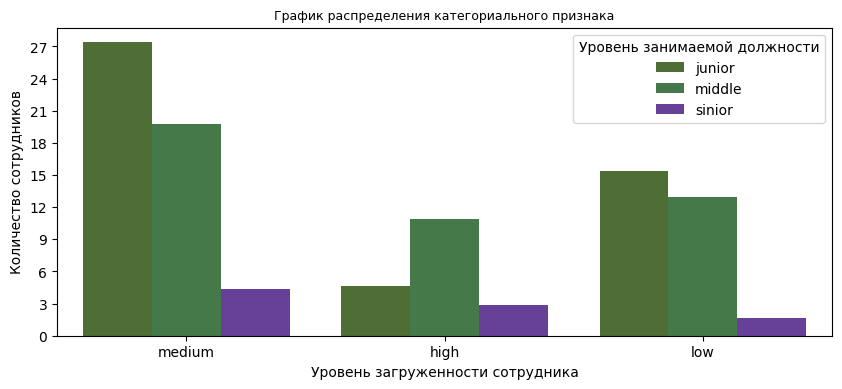

In [29]:
# workload
hist_countolot(
    train_job_satisfaction_rate, 
    'workload', 
    'Уровень загруженности сотрудника'
)

Данный признак нужно будет обработать OrdinalEncoder, потому что присутствуют ранговые категории.

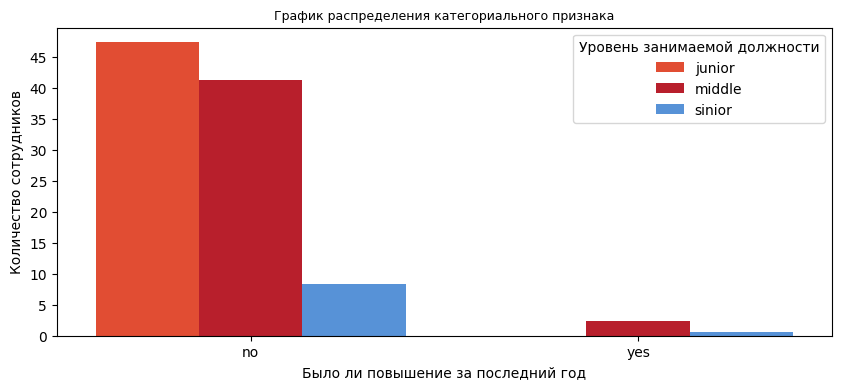

In [30]:
# last_year_promo
hist_countolot(
    train_job_satisfaction_rate, 
    'last_year_promo', 
    'Было ли повышение за последний год'
)

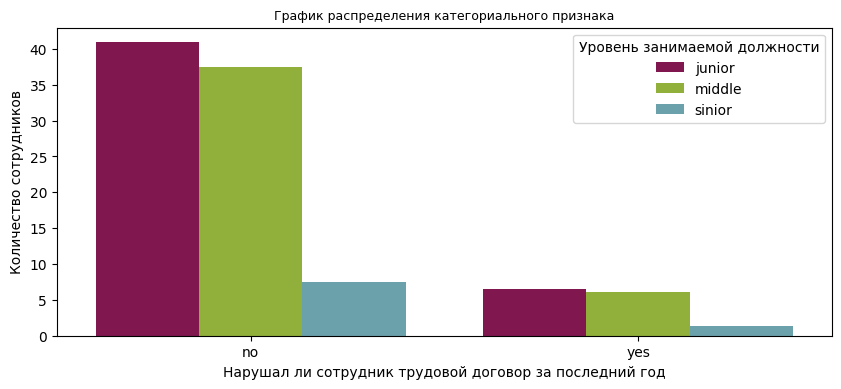

In [31]:
# last_year_violations
hist_countolot(
    train_job_satisfaction_rate, 
    'last_year_violations', 
    'Нарушал ли сотрудник трудовой договор за последний год'
)

### Тестовая выборка

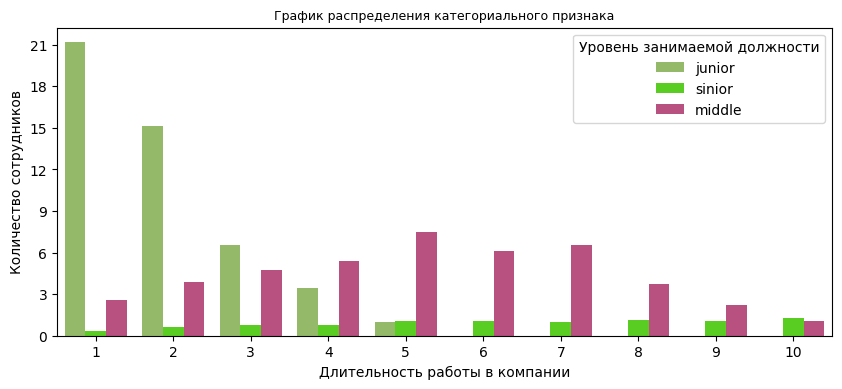

In [32]:
# employment_years
hist_countolot(
    train_job_satisfaction_rate, 
    'employment_years', 
    'Длительность работы в компании'
) 

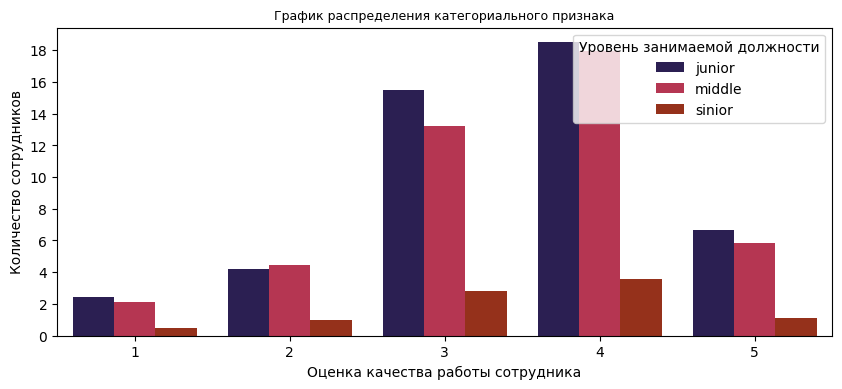

In [33]:
# supervisor_evaluation
hist_countolot(
    train_job_satisfaction_rate, 
    'supervisor_evaluation', 
    'Оценка качества работы сотрудника'
) 

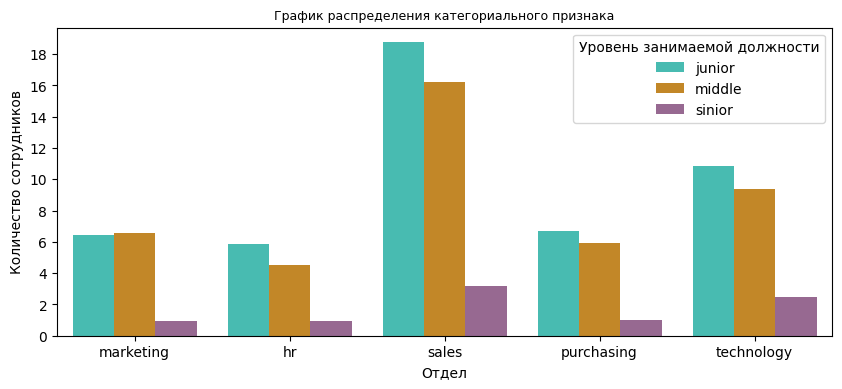

In [34]:
# dept
hist_countolot(
    test_features, 
    'dept', 
    'Отдел'
) 

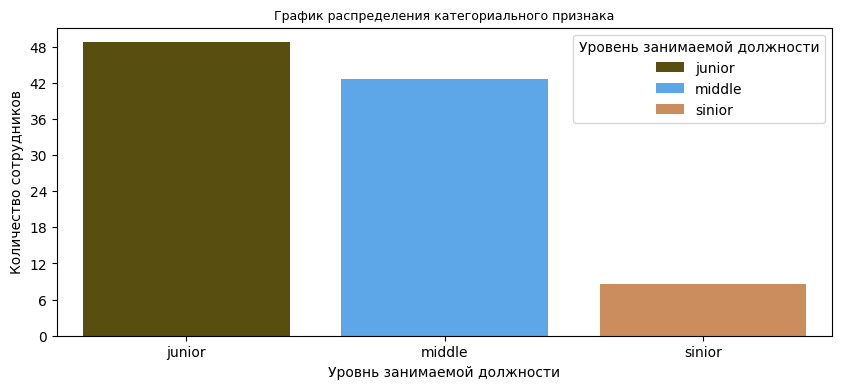

In [35]:
# level
hist_countolot(
    test_features, 
    'level', 
    'Уровнь занимаемой должности'
)

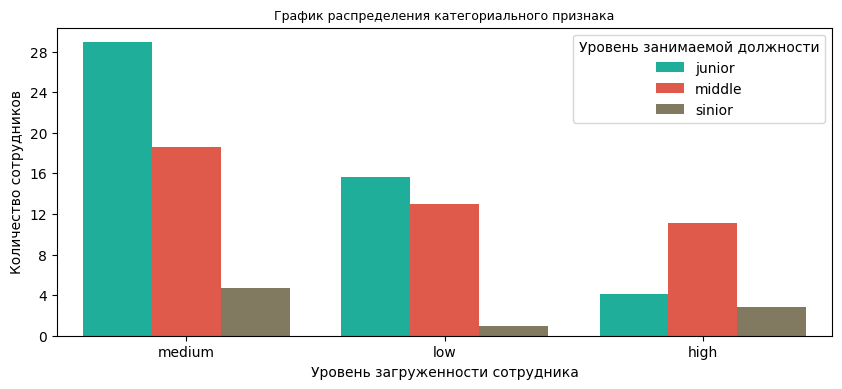

In [36]:
# workload
hist_countolot(
    test_features, 
    'workload', 
    'Уровень загруженности сотрудника'
)

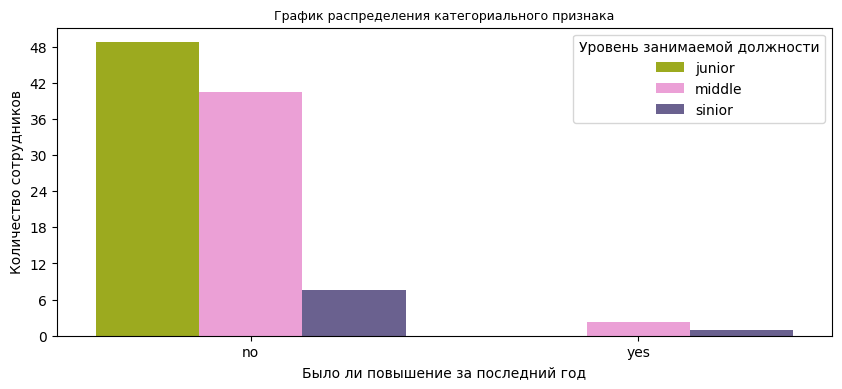

In [37]:
# last_year_promo
hist_countolot(
    test_features, 
    'last_year_promo', 
    'Было ли повышение за последний год'
)

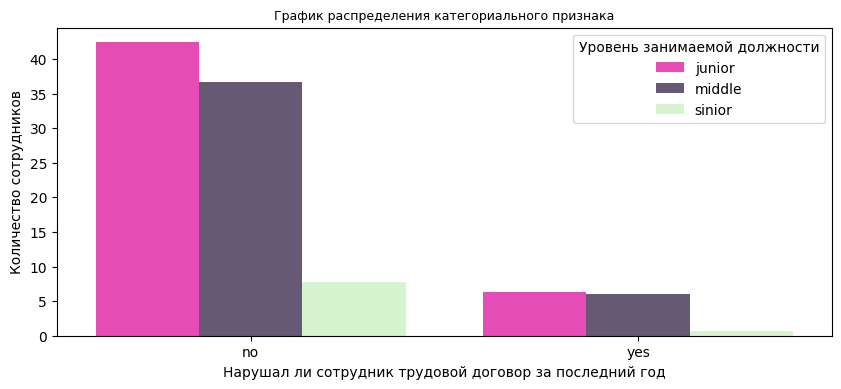

In [38]:
# last_year_violations
hist_countolot(
    test_features, 
    'last_year_violations', 
    'Нарушал ли сотрудник трудовой договор за последний год'
)

## Корреляционный анализ

Изучим взаимосвязь между целевым и входными признаками. Для начала изучим распределение количественных признаков

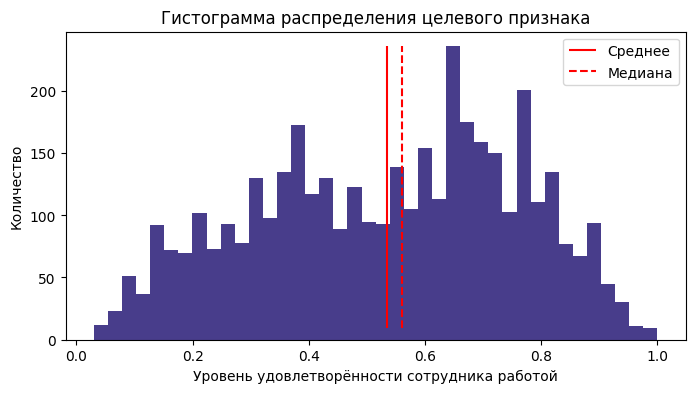

In [39]:
# распределение целевого признака
plt.rcParams["figure.figsize"] = (8, 4)
bins = plt.hist(
    train_job_satisfaction_rate.job_satisfaction_rate, 
    bins=40, 
    color='darkslateblue'
)
plt.vlines(
    x=train_job_satisfaction_rate.job_satisfaction_rate.mean(), 
    colors='red',
    ymin=bins[0].min(), 
    ymax=bins[0].max(), 
    label='Среднее')
plt.vlines(
    x=train_job_satisfaction_rate.job_satisfaction_rate.median(), 
    colors='red', 
    ymin=bins[0].min(),
    ymax=bins[0].max(), 
    linestyles='--', 
    label='Медиана'
)
plt.title('Гистограмма распределения целевого признака')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.ylabel('Количество')
plt.legend()
plt.show()

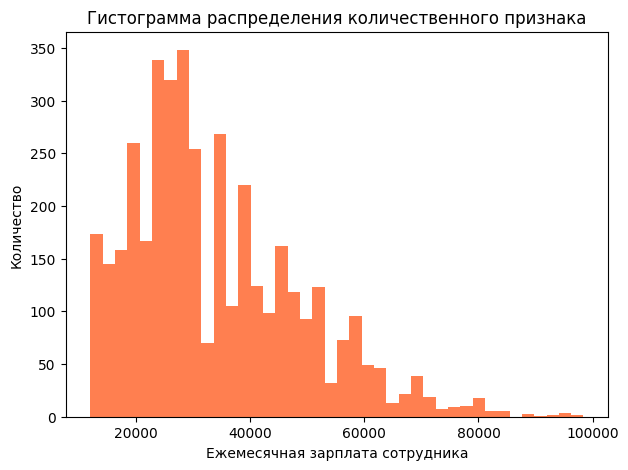

In [40]:
# распределение количественного признака
plt.rcParams["figure.figsize"] = (7, 5)
bins = plt.hist(
    train_job_satisfaction_rate.salary, 
    bins=40, 
    color='coral'
)
plt.title('Гистограмма распределения количественного признака')
plt.xlabel('Ежемесячная зарплата сотрудника')
plt.ylabel('Количество')
plt.show()

Целевой признак имеет нормальное распределение, другой количиственный признак имеет не нормальное распределение. 
Используем коэффициент корреляции Спирмена или Кендалла. Учтем, что корреляционные связи в подгруппах могут различаться.

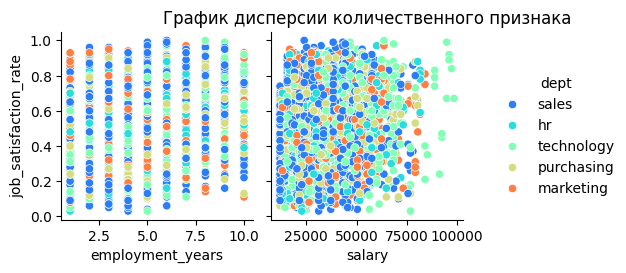

In [41]:
# диаграмма рассеяния
sns.pairplot(train_job_satisfaction_rate, 
             hue='dept', 
             palette='rainbow',
    x_vars=['employment_years', 'salary'],
    y_vars=['job_satisfaction_rate']
            )

plt.title('График дисперсии количественного признака')
plt.show()

Исследуем кореляцию признаков с помощью библиотеки `phik`

In [42]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['job_satisfaction_rate', 'salary']

# считаем корреляцию
phik_overview = phik_matrix(
    train_job_satisfaction_rate.drop(
        ['id'],
        axis=1
    ),
    interval_cols=interval_cols) 

# размер матрицы
phik_overview.shape

(9, 9)

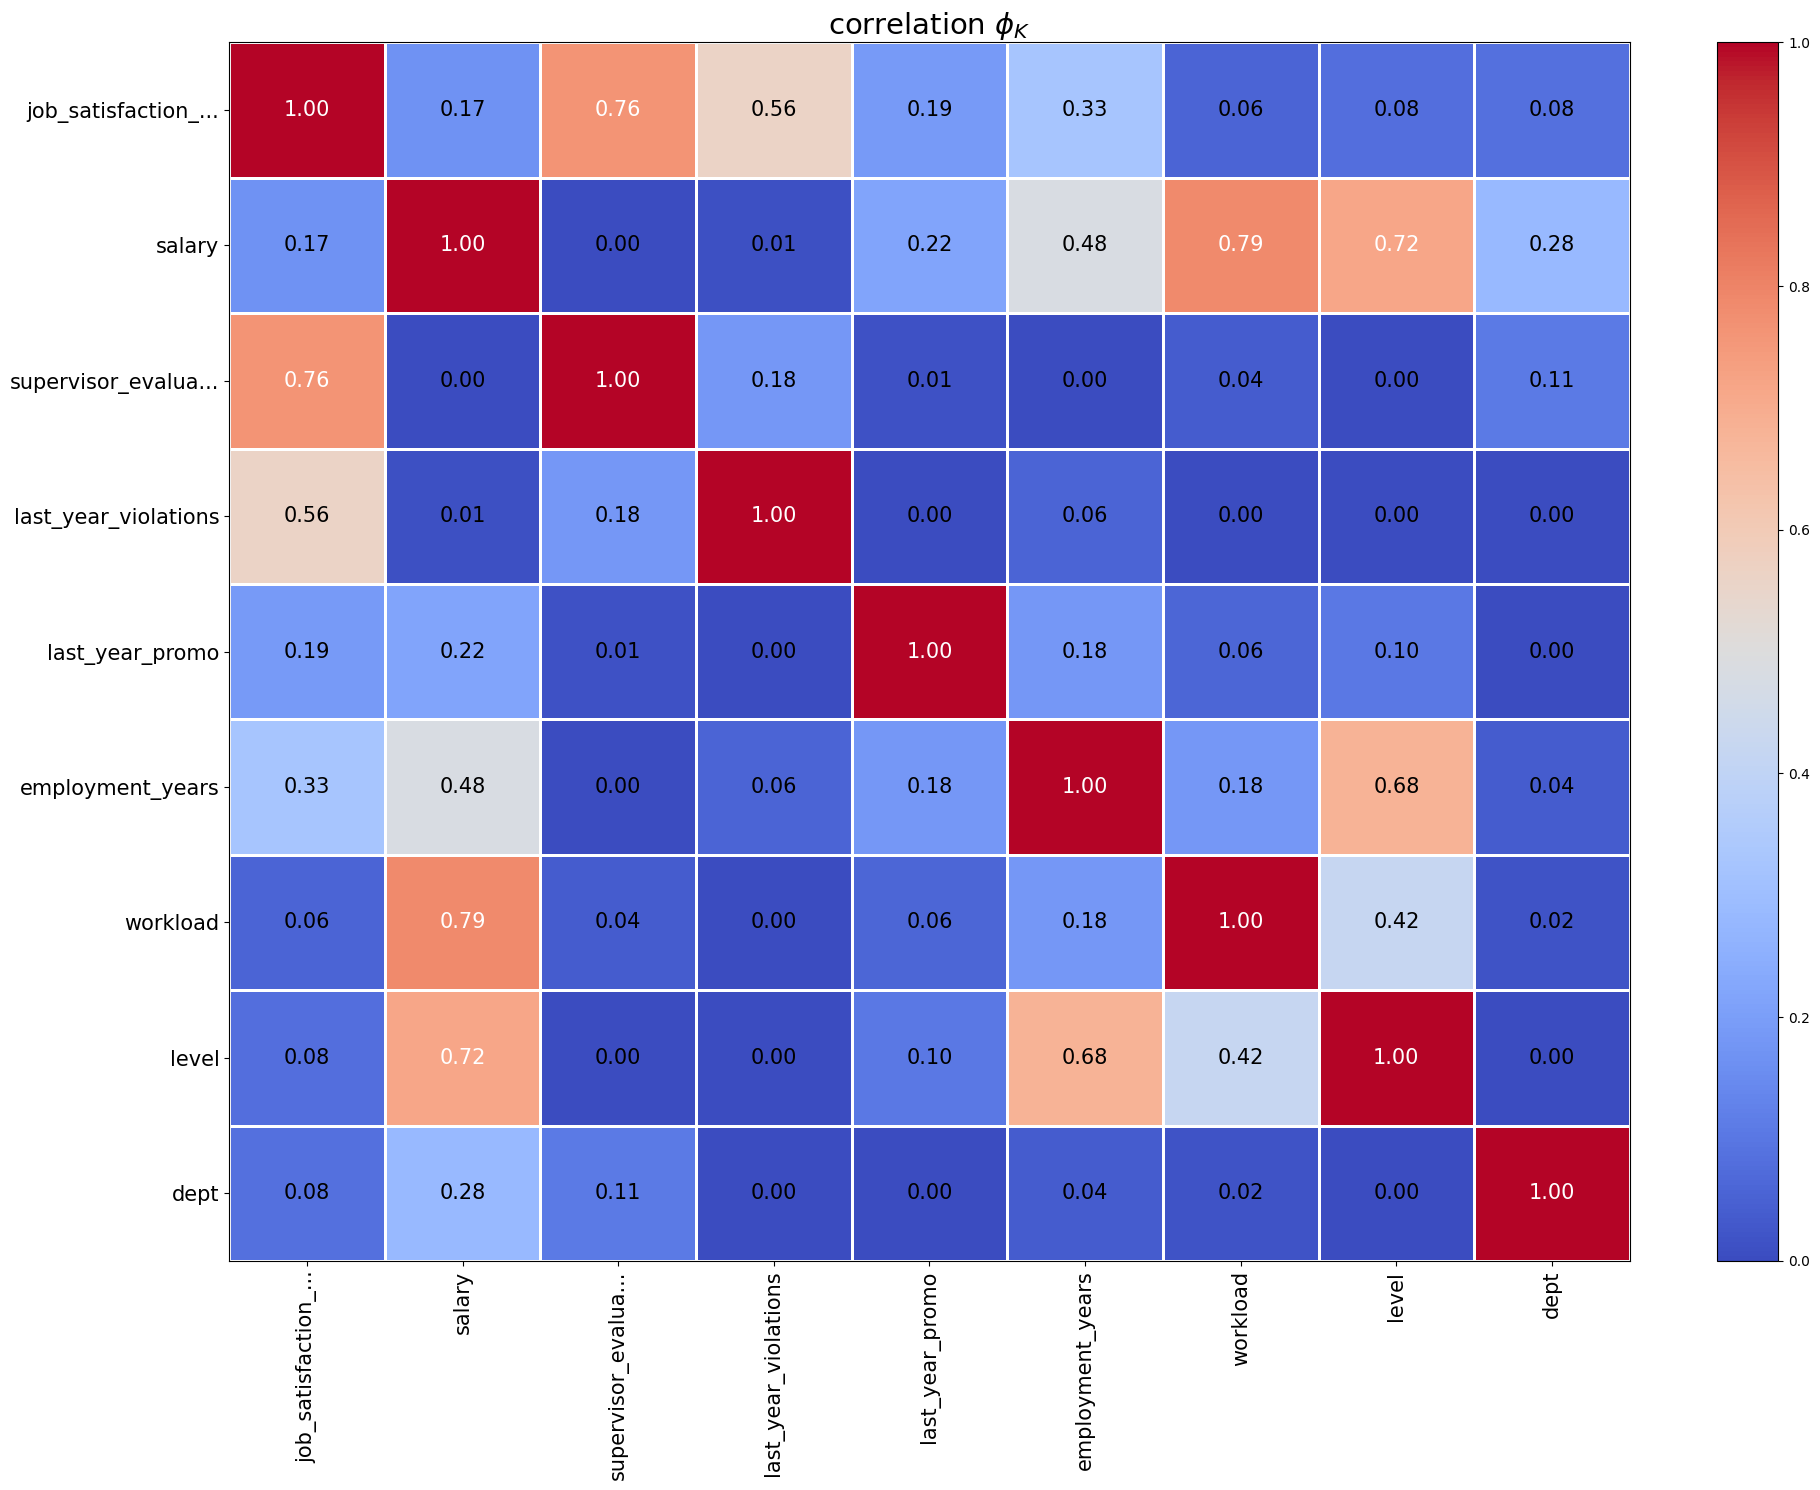

In [43]:
# визуализация
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

## Промежуточный вывод

В данном разделе выделим следующие моменты касательно признаков:

При визуализации ясно следующее:

- есть небольшое количество выбросов в **train_job_satisfaction_rate -> salary -> junior**;
- есть небольшое количество выбросов в **test_features -> salary -> junior**;
- большее количество сотрудников работает в отделе продаж;
- признаки **train_job_satisfaction_rate.level, train_job_satisfaction_rate.workload** нужно обработать `OrdinalEncoder`, потому что присутствуют ранговые категории;
- самый распространеннй уровень должности - junior и middle;
- в основном у сотрудников средний уровень загруженности;
- сотрудников очень редко повышвали в должности;
- в основном сотрудники не нарушали трудовой договор;
- самая частая оценка качества работы сотрудника - 4;
- остальные признаки обработаем масштабированием.

Целевой признак имеет нормальное распределение, другие количиственные признаки имеют не нормальное распределение. 

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:

- теплые тона говорят о сильной линейной зависимости, а холодные — о слабой;
- корреляция между целевым и остальными достаточно слабая, кроме **supervisor_evaluation, last_year_violations**;
- есть высокая корреляция между парами **salary -> level**, **salary -> workload**, **employment_years -> level**;
- мультиколлинеарность отсутствует, так как порог для подтверждения 0.9-0.95;
- утечки целевого признака через входящие не наблюдается.

# Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки. Используем как минимум два кодировщика.

In [44]:
# сортируем данные по столбцу id
test_features = test_features.sort_values(by='id', ascending=True)
test_target_job_satisfaction_rate = (
    test_target_job_satisfaction_rate
    .sort_values(by='id', ascending=True)
)

In [45]:
RANDOM_STATE = 42
TEST_SIZE = 0.5

X_train = (
    train_job_satisfaction_rate
    .drop(
        [
            'id', 
            'job_satisfaction_rate'
        ],
        axis=1
        )
)
X_test = (
    test_features
    .drop(
        ['id'],
        axis=1
    )
)
y_train = train_job_satisfaction_rate.job_satisfaction_rate
y_test = test_target_job_satisfaction_rate.job_satisfaction_rate


ohe_columns = [
    'dept', 
    'last_year_promo', 
    'last_year_violations',
    'employment_years', 
    'supervisor_evaluation'
    ]

ord_columns = [
    'level', 
    'workload'
    ]

num_columns = [
    'salary'
]

# пайплайн подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        # заполним пропуски
        (
            'simpleImputer_ohe_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),

        # заполним пропуски, которые появляются после Ordinal-кодирования.
        (
            'simpleImputer_ohe_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# пайплайн подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_num_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

        (
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        
        (
            'simpleImputer_num_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

# пайплайн подготовки признаков из списка num_columns
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num_before', 
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),

        (
            'num', 
            MinMaxScaler()
        ),
        
        (
            'simpleImputer_num_after',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
    ]
    )

# код для пайплайна подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        
        # используем смесь андерсэмплинга с оверсэмплингом SMOTETomek
        ('models', SMOTETomek(random_state=RANDOM_STATE))
    ]
)

# Обучение моделей

## Три модели

Обучим две модели. Возьмем одну линейную модель, а в качестве второй — дерево решений. Подберем гиперпараметры 
как минимум для одной модели.

In [46]:
# обучим пайплайн на тренировочных данных
pipe_final.fit(X_train, y_train)

# преобразуем тренировочную и тестовую выборку
X_train_pipe = pipe_final.named_steps['preprocessor'].transform(X_train)
X_test_pipe = pipe_final.named_steps['preprocessor'].transform(X_test)

# для данных OHE названия столбцов укажем из шага пайплайна 
X_train_pipe_df = pd.DataFrame(
    X_train_pipe,
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
X_test_pipe_df = pd.DataFrame(
    X_test_pipe,
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()    
)

In [47]:
# собственная функция для расчета SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# скорер на основе показателя эффективности
scorer = make_scorer(smape, greater_is_better=False)

## SVR

In [48]:
# выбор модели
model_svr = SVR()

# гиперпараметры
param_grid_svr = {
    'degree': range(3, 4),
    'C': range(5, 10),
    'kernel': ['rbf', 'linear', 'sigmoid', 'poly']
}

# инициализация
grid_search_svr = GridSearchCV(
    model_svr,
    param_grid_svr,
    scoring=scorer,
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_svr.fit(X_train_pipe_df, y_train)

# данные подбора
display(f'Лучшие араметры SMAPE: {round(grid_search_svr.best_score_ * -1, 2)}%')
display(f'Лучшие араметры: {grid_search_svr.best_params_}')

'Лучшие араметры SMAPE: 13.89%'

"Лучшие араметры: {'C': 9, 'degree': 3, 'kernel': 'rbf'}"

## LinearRegression

In [49]:
# выбор модели
model_lr = LinearRegression(n_jobs=-1)

# гиперпараметры
param_grid_lr = {
    'fit_intercept': [False, True] # нужно ли вычислять свободный член
}

# инициализация
grid_search_lr = GridSearchCV(
    model_lr,
    param_grid_lr,
    scoring=scorer,
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_lr.fit(X_train_pipe_df, y_train)

# данные подбора
display(f'Лучшие араметры SMAPE: {round(grid_search_lr.best_score_ * -1, 2)}%')
display(f'Лучшие араметры: {grid_search_lr.best_params_}')

'Лучшие араметры SMAPE: 16.88%'

"Лучшие араметры: {'fit_intercept': True}"

## DecisionTreeRegressor

In [50]:
# выбор модели
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

# гиперпараметры
param_grid_dtr = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random'],
    'min_samples_split': range(6, 10),
    'max_depth': range(2, 6)
}

# инициализация
grid_search_dtr = GridSearchCV(
    model_dtr,
    param_grid_dtr,
    scoring=scorer,
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_dtr.fit(X_train_pipe_df, y_train)

# данные подбора
display(f'Лучшие араметры SMAPE: {round(grid_search_dtr.best_score_ * -1, 2)}%')
display(f'Лучшие араметры: {grid_search_dtr.best_params_}')

'Лучшие араметры SMAPE: 22.65%'

"Лучшие араметры: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_split': 6, 'splitter': 'best'}"

## Лучшая модель

Выберем лучшую модель и проверимеё качество. Выбор сделаем на основе метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Сравним модели по ключевой метрике на тенировочных данных.

In [51]:
# словарь для сравнения моделей
models_scorer = {
    'SVR': grid_search_svr.best_estimator_,
    'LinearRegression': grid_search_lr.best_estimator_,
    'DecisionTreeRegressor': grid_search_dtr.best_estimator_
}

# вывод значения метрки для каждой модели
for name, model in models_scorer.items():
    scores = cross_val_score(model, X_train_pipe_df, y_train, cv=5, scoring=scorer).mean() * -1
    print(f'{name}: {scores:.2f}%')

SVR: 13.89%
LinearRegression: 16.88%
DecisionTreeRegressor: 22.65%


Лидирует `SVR`, проверим на тестовых данных

In [52]:
# лучшая модель SVR
best_model_svr = grid_search_svr.best_estimator_

# предсказание
y_pred_svr = best_model_svr.predict(X_test_pipe_df)
print(f'SMAPE SVR: {smape(y_test, y_pred_svr):.2f}%')

SMAPE SVR: 12.95%


## Вывод

На основе метрики симметричное среднее абсолютное процентное отклонение лучший показатель на тренировочных данных у модели 
`SVR` на тесте 12.95%

**Задача 2: предсказание увольнения сотрудника из компании**

Использовать те же входные признаки, что и в предыдущей задаче. Целевой признак отличается: это **quit** — увольнение сотрудника из компании.

# Загрузка данных

Загрузим данные из файлов

Тренировочная выборка:

- train_quit.csv
  
Входные признаки тестовой выборки те же, что и в прошлой задаче:

- test_features.csv

Целевой признак тестовой выборки:

- test_target_quit.csv

In [ ]:
    train_quit = pd.read_csv(
        r'...\train_quit.csv')
    test_target_quit = pd.read_csv(
        r'...\test_target_quit.csv')
    
except:
    train_quit = pd.read_csv('.../train_quit.csv')
    test_target_quit = pd.read_csv('.../test_target_quit.csv')

## Выведем первые строки каждого набора данных

In [54]:
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [55]:
display(test_target_quit.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


# Предобработка данных

Изучим данные и при необходимости выполним предобработку. Если есть пропуски, заполним их в пайплайне.

## Проверка данных на соответствие техническому описанию

In [56]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [57]:
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [58]:
train_quit.quit.value_counts(normalize=True)

quit
no     0.718
yes    0.282
Name: proportion, dtype: float64

Присутствует дисбаланс классов

In [59]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [60]:
display(test_target_quit.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [61]:
# проверим дубликаты
train_quit[train_quit['id'].duplicated(keep='last')].sort_values(by='id')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


In [62]:
train_quit.columns.unique()

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

# Исследовательский анализ данных

Проведем исследовательский анализ данных.

## Статистический анализ признаков

### Тренировочная выборка

In [63]:
(
    train_quit
    .select_dtypes(include='number')
    .drop(['id', 'employment_years', 'supervisor_evaluation'], axis=1)
    .describe()
    .style.format('{:,.0f}')
)

,salary
count,"4,000"
mean,"33,806"
std,"15,152"
min,"12,000"
25%,"22,800"
50%,"30,000"
75%,"43,200"
max,"96,000"


Значения выглядят адекватно

## График количиственных признаков

### Тренировочная выборка

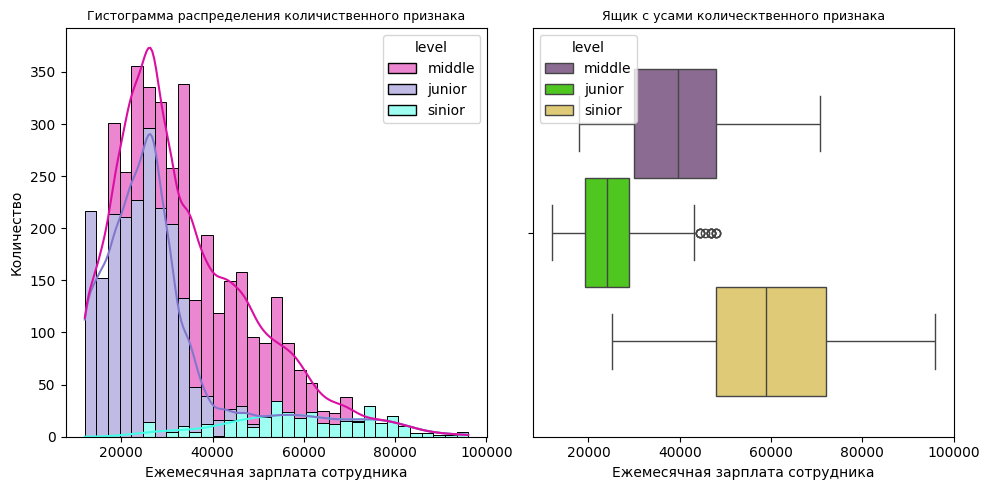

In [64]:
# salary
hist_box_num_sub(
    train_quit.level.unique(),
    train_quit, 
    'salary', 
    'Гистограмма распределения количиственного признака', 
    'Ежемесячная зарплата сотрудника', 
    'Количество'
)

## Графики категориальных признаков

### Тренировочная выборка

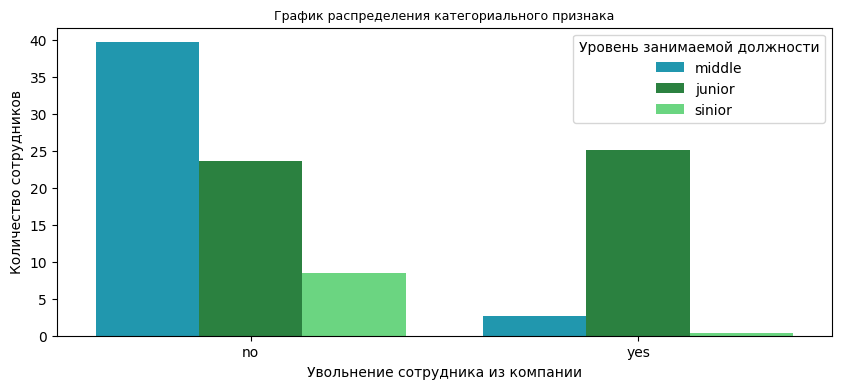

In [65]:
# целевой признак
hist_countolot(
    train_quit, 
    'quit', 
    'Увольнение сотрудника из компании'
)

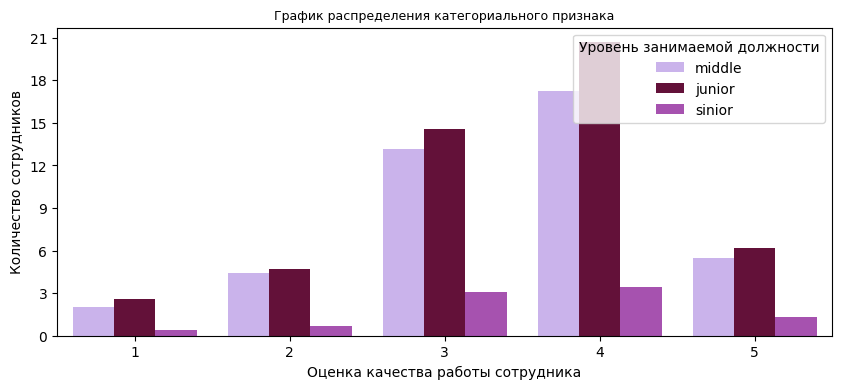

In [66]:
# supervisor_evaluation
hist_countolot(
    train_quit, 
    'supervisor_evaluation', 
    'Оценка качества работы сотрудника'
) 

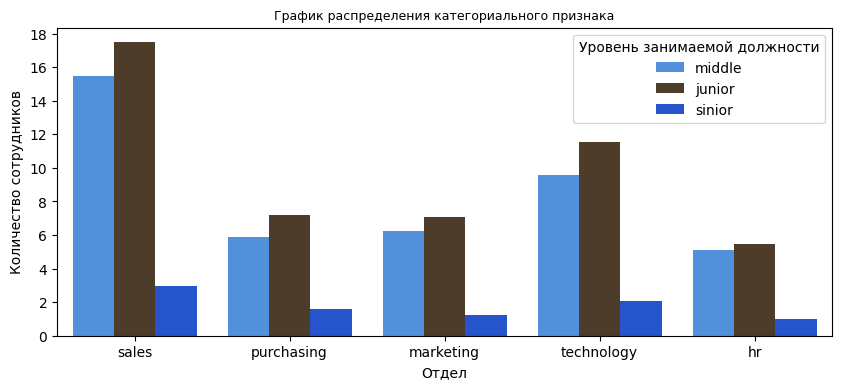

In [67]:
# dept
hist_countolot(
    train_quit, 
    'dept', 
    'Отдел'
)

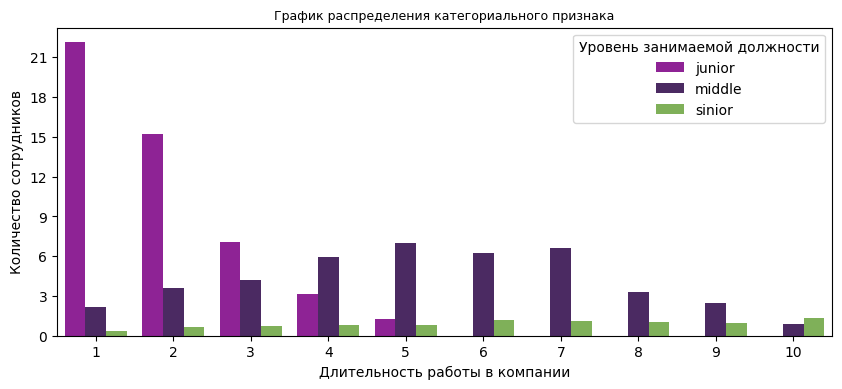

In [68]:
# employment_years
hist_countolot(
    train_quit, 
    'employment_years', 
    'Длительность работы в компании'
)

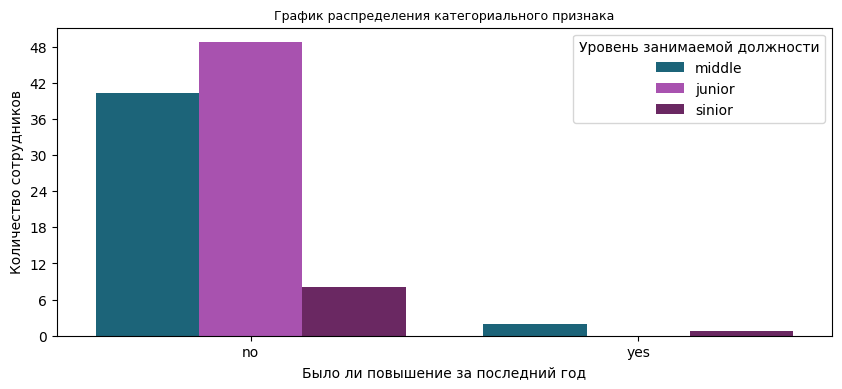

In [69]:
# last_year_promo
hist_countolot(
    train_quit, 
    'last_year_promo', 
    'Было ли повышение за последний год'
)

C:\Users\ripzo\AppData\Local\Temp\ipykernel_6640\1738864530.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Уровень занимаемой должности', loc='upper right')


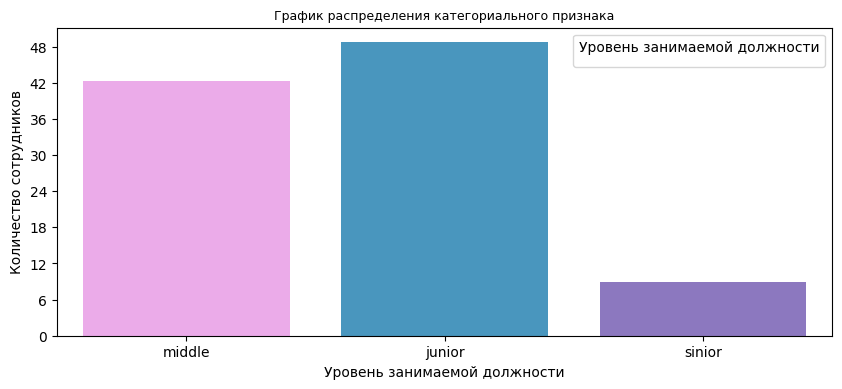

In [70]:
# level
hist_countolot(
    train_quit, 
    'level', 
    'Уровень занимаемой должности'
)

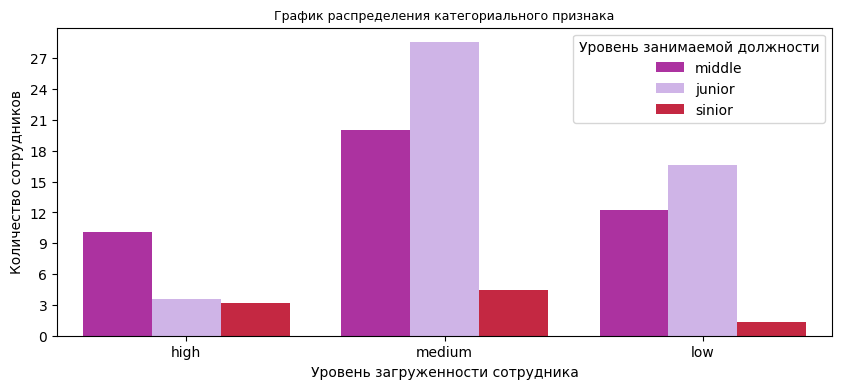

In [71]:
# workload
hist_countolot(
    train_quit, 
    'workload', 
    'Уровень загруженности сотрудника'
)

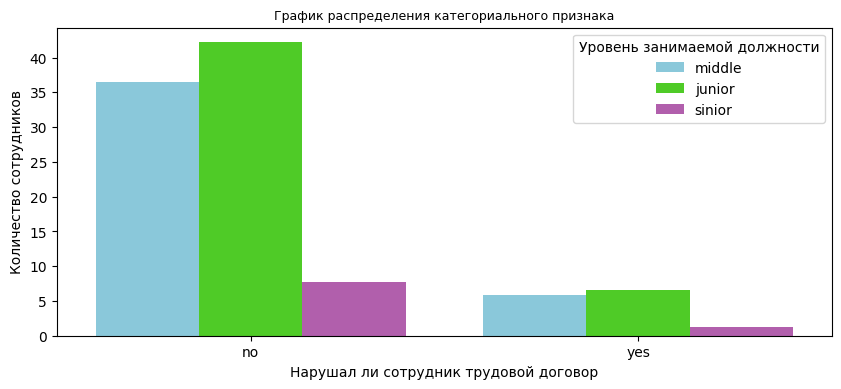

In [72]:
# last_year_violations
hist_countolot(
    train_quit, 
    'last_year_violations', 
    'Нарушал ли сотрудник трудовой договор'
)

### Тестовая выборка

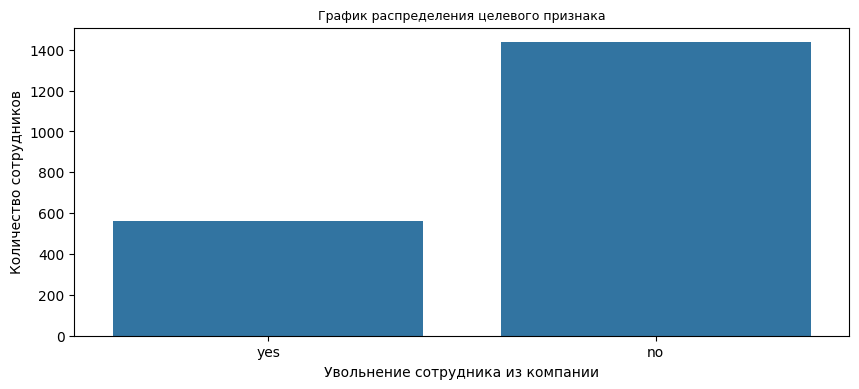

In [73]:
# гистограмма целевого признака
plt.figure(figsize=(10, 4))
sns.countplot(
    test_target_quit,
    x='quit',
    )
plt.title('График распределения целевого признака',  fontsize=9)
plt.xlabel('Увольнение сотрудника из компании')
plt.ylabel('Количество сотрудников')
plt.show()

## Корреляционный анализ

Изучим взаимосвязь между целевым и входными признаками. Для начала изучим распределение количественных признаков

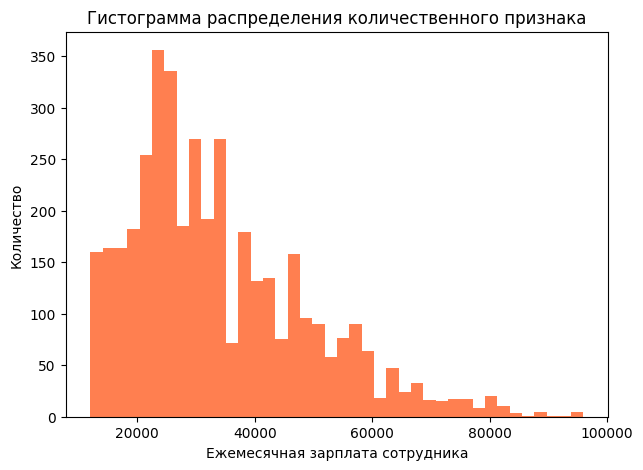

In [74]:
# распределение целевого признака
plt.rcParams["figure.figsize"] = (7, 5)
bins = plt.hist(
    train_quit.salary, 
    bins=40, 
    color='coral'
)
plt.title('Гистограмма распределения количественного признака')
plt.xlabel('Ежемесячная зарплата сотрудника')
plt.ylabel('Количество')
plt.show()

Исследуем кореляцию признаков с помощью библиотеки `phik`

In [75]:
# создаём список с наименованиями непрерывных признаков
interval_cols_two = ['salary']

# считаем корреляцию
phik_overview_two = phik_matrix(
    train_quit.drop(
        ['id'],
        axis=1
    ),
    interval_cols=interval_cols_two) 
  
# размер матрицы
phik_overview_two.shape

(9, 9)

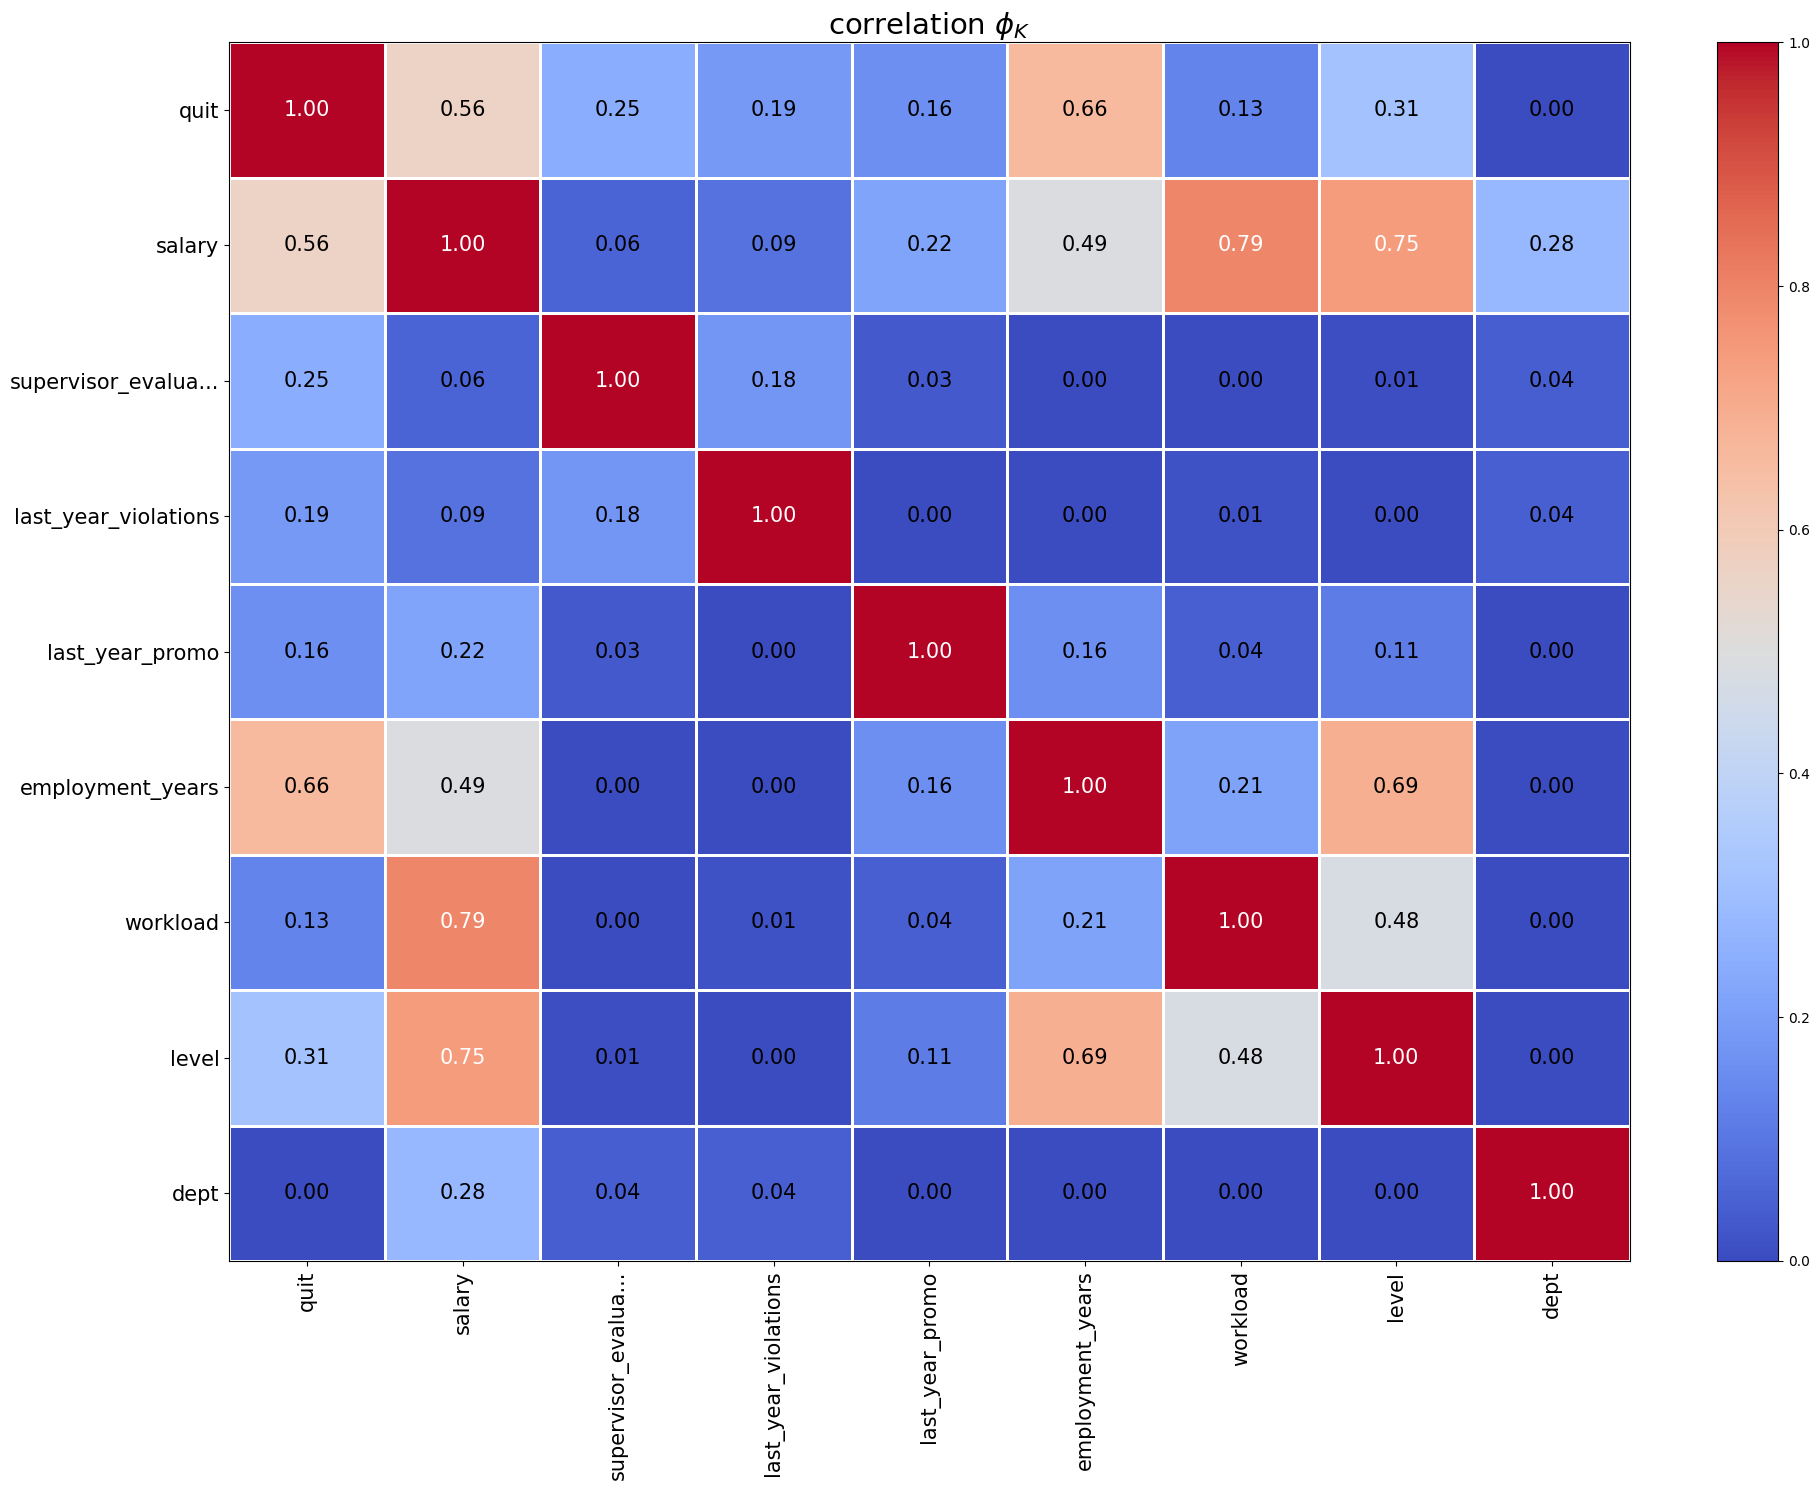

In [76]:
# визуализация
plot_correlation_matrix(
    phik_overview_two.values,
    x_labels=phik_overview_two.columns,
    y_labels=phik_overview_two.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

## Промежуточный вывод

В данном разделе выделим следующие моменты касательно признаков:

При визуализации ясно следующее:

- есть небольшое количество выбросов в **train_quit -> salary -> junior**;
- большее количество сотрудников работает в отделе продаж;
- признаки **train_job_satisfaction_rate.level, train_job_satisfaction_rate.workload** нужно обработать `OrdinalEncoder`, потому что присутствуют ранговые категории;
- самый распространеннй уровень должности - junior и middle;
- в основном у сотрудников средний уровень загруженности;
- сотрудников очень редко повышвали в должности;
- в основном сотрудники не нарушали трудовой договор;
- самая частая оценка качества работы сотрудника - 4;
- остальные признаки обработаем масштабированием.

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:

- теплые тона говорят о сильной линейной зависимости, а холодные — о слабой;
- корреляция между целевым и остальными достаточно слабая, кроме **salary, last_year_violations**;
- есть высокая корреляция между парами **salary -> level**, **salary -> workload**, **employment_years -> level**;
- мультиколлинеарность отсутствует, так как порог для подтверждения 0.9-0.95;
- утечки целевого признака через входящие не наблюдается.

## Портрет «уволившегося сотрудника»

In [77]:
# категориальные признаки
list_table = ['dept', 'workload', 'level', 
              'employment_years', 'last_year_promo', 
              'last_year_violations', 'supervisor_evaluation']

# результат работы цикла
results_portrait = {}
for i in list_table:
    pivot_table = (
        train_quit
        .query('quit == "yes"')
        .groupby(i, as_index=False)
        .agg(employees=(i, 'count'))
        .set_index(i)
        .sort_values(by='employees', ascending=False)
        .astype({'employees': 'int'})
    )
    pivot_table['decimal,%'] = round((
        pivot_table.employees / pivot_table.employees.sum()
    ) * 100, 1)
    results_portrait[i] = pivot_table

In [78]:
results_portrait['dept']

,employees,"decimal,%"
dept,,
sales,407,36.1
technology,276,24.5
purchasing,166,14.7
marketing,163,14.5
hr,116,10.3


Самое большое количество уволиышихся сотрудников в 38.3% работали в отделе продаж.

In [79]:
results_portrait['workload']

,employees,"decimal,%"
workload,,
low,519,46.0
medium,488,43.3
high,121,10.7


Самое большое количество уволиышихся сотрудников в 45.6% работали с низкой загруженностью.

In [80]:
results_portrait['level']

,employees,"decimal,%"
level,,
junior,1003,88.9
middle,108,9.6
sinior,17,1.5


Самое большое количество уволившихся сотрудников в 89.6% работали в юниорами.

In [81]:
results_portrait['employment_years']

,employees,"decimal,%"
employment_years,,
1,599,53.1
2,290,25.7
3,163,14.5
4,27,2.4
5,23,2.0
6,10,0.9
7,7,0.6
8,3,0.3
9,3,0.3


Самое большое количество уволившихся сотрудников в 56.3% работали один год.

In [82]:
results_portrait['last_year_promo']

,employees,"decimal,%"
last_year_promo,,
no,1127,99.9
yes,1,0.1


Самое большое количество уволившихся сотрудников в 100% работали без повышения.

In [83]:
results_portrait['last_year_violations']

,employees,"decimal,%"
last_year_violations,,
no,900,79.8
yes,228,20.2


Самое большое количество уволившихся сотрудников в 81.7% работали без нарушений.

In [84]:
results_portrait['supervisor_evaluation']

,employees,"decimal,%"
supervisor_evaluation,,
3,523,46.4
4,286,25.4
2,164,14.5
1,95,8.4
5,60,5.3


Самое большое количество уволившихся сотрудников в 49.7% работали с оценкой руководителя в 3 балла.

In [85]:
# сводная таблица средней зарплаты
(
    train_quit.groupby('quit', as_index=False)
    .agg(mean_salary = ('salary', 'mean'))
    .set_index('quit')
    .sort_values(by='mean_salary', ascending=True)
    .astype('int')
)

,mean_salary
quit,
yes,23885
no,37702


Итак, получаем рецепт, как повлиять на уволнение сотрудника:

- отдел, в котором работает сотрудник - продажи;
- уровень загруженности - низкая;
- уровень занимаемой должности - юниор;
- длительность работы в компании - год;
- робота без повышения;
- робота без нарушений;
- оценка качества работы сотрудника, которую дал руководитель - 3 балла.

Процентное соотношение уволившихся:
- самое большое количество уволившихся сотрудников в 38.3% работали в отделе продаж.
- самое большое количество уволившихся сотрудников в 45.6% работали с низкой загруженностью.
- самое большое количество уволившихся сотрудников в 89.6% работали в юниорами.
- самое большое количество уволившихся сотрудников в 56.3% работали один год.
- самое большое количество уволившихся сотрудников в 100% работали без повышения.
- самое большое количество уволившихся сотрудников в 81.7% работали без нарушений.
- самое большое количество уволившихся сотрудников в 49.7% работали с оценкой руководителя в 3 балла.

## Влияние удовлетворенности

Визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников.

In [86]:
# объединим
test_target_quit = (
    test_target_quit
    .sort_values(by='id', ascending=True)
    .merge(test_target_job_satisfaction_rate, on='id')
)

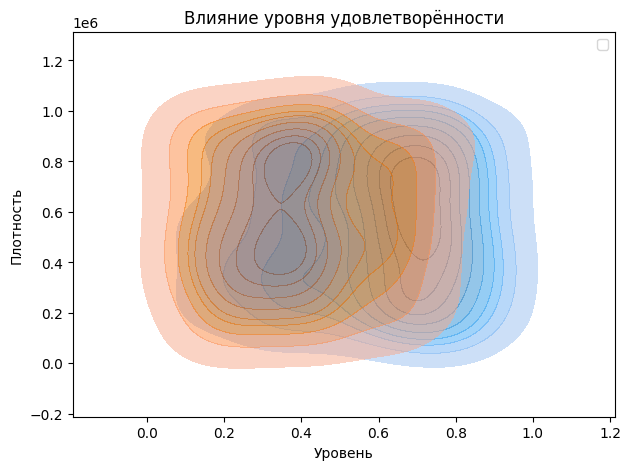

In [87]:
# вариант один
sns.kdeplot(
    data=test_target_quit, 
    x='job_satisfaction_rate', 
    y='id', 
    hue='quit', 
    bw_adjust=1.2,
    fill=True,
    alpha=.5,
    common_norm=False,
)

plt.legend(['Уволен', 'Не уволен'], loc='upper right')
plt.title('Влияние уровня удовлетворённости')
plt.xlabel('Уровень')
plt.ylabel('Плотность')
plt.show()

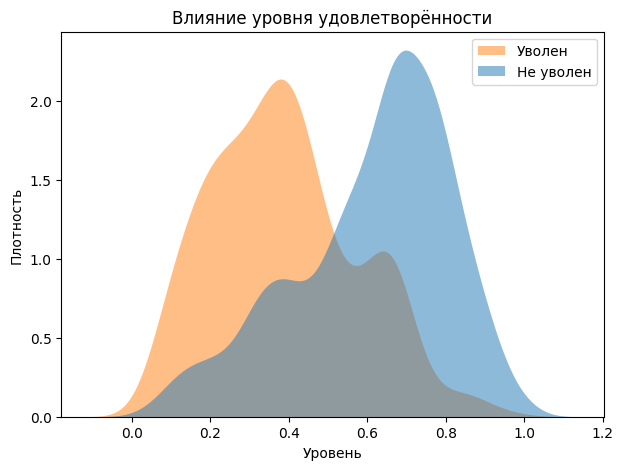

In [88]:
# вариант два
sns.kdeplot(
    test_target_quit, 
    x='job_satisfaction_rate', 
    hue='quit',
    fill=True, 
    common_norm=False, 
    alpha=.5, 
    linewidth=0
)

plt.legend(['Уволен', 'Не уволен'], loc='upper right')
plt.title('Влияние уровня удовлетворённости')
plt.xlabel('Уровень')
plt.ylabel('Плотность')
plt.show()

In [89]:
(
    test_target_quit
    .groupby('quit', as_index=False)
    .agg(employees = ('quit', 'count'),
         mean_satisfaction_rate = ('job_satisfaction_rate', 'mean'))
    .set_index('quit')
    .sort_values(by='employees', ascending=False)
    .round(2)
    )

,employees,mean_satisfaction_rate
quit,,
no,1436,0.61
yes,564,0.39


Судя по графикам и таблице, уровень удовлетворённости влияет на увольнение сотрудника.

# Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [90]:
# перобразуем массив
y_pred_svr_df = pd.DataFrame(y_pred_svr, columns=['job_satisfaction_rate'])

# объединение
train_quit = (
    train_quit
    .sort_values(by='id', ascending=True)
    .join(y_pred_svr_df, how='right')
)       
test_features = test_features.merge(test_target_job_satisfaction_rate, on='id')

# Подготовка данных

Подготовим признаки как и в первой задаче и используем два кодировщика.

In [91]:
RANDOM_STATE = 42
TEST_SIZE = 0.5

X_train_quit = (
    train_quit
    .drop(
        ['id', 'quit'],
        axis=1
    )
)
X_test_quit = (
    test_features
    .drop(
        ['id'],
        axis=1
    )
)
y_train_quit = train_quit.quit
y_test_quit = test_target_quit.quit


ohe_columns = [
    'dept',
    'last_year_promo', 
    'last_year_violations',
    'supervisor_evaluation'
    ]

ord_columns = [
    'level', 
    'workload'
    ]

num_columns = [
    'salary',
    'employment_years',
    'job_satisfaction_rate'
]

# пайплайн подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),

        # заполним пропуски, которые появляются после Ordinal-кодирования.
        (
            'simpleImputer_ohe_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# пайплайн подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_num_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

        (
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        
        (
            'simpleImputer_num_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

# пайплайн подготовки признаков из списка num_columns
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num_before', 
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),

        (
            'num', 
            RobustScaler()
        ),
        
        (
            'simpleImputer_num_after',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
    ]
    )

# код для пайплайна подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final_quit = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        
        # используем смесь андерсэмплинга с оверсэмплингом SMOTETomek
        ('models', SMOTETomek(random_state=RANDOM_STATE))
    ]
)

# Обучение модели

Обучим три модели и подберем гиперпараметры, проверим качество лучшей модели.

In [92]:
# обучим пайплайн на тренировочных данных
pipe_final_quit.fit(X_train_quit, y_train_quit)

# преобразуем тренировочную и тестовую выборку
X_train_quit_pipe = pipe_final_quit.named_steps['preprocessor'].transform(X_train_quit)
X_test_quit_pipe = pipe_final_quit.named_steps['preprocessor'].transform(X_test_quit)

# для данных OHE названия столбцов укажем из шага пайплайна 
X_train_quit_pipe_df = pd.DataFrame(
    X_train_quit_pipe,
    columns=pipe_final_quit.named_steps['preprocessor'].get_feature_names_out()
)
X_test_quit_pipe_df = pd.DataFrame(
    X_test_quit_pipe,
    columns=pipe_final_quit.named_steps['preprocessor'].get_feature_names_out()    
)

# кодируем целевой признак
le = LabelEncoder()
y_train_quit = le.fit_transform(y_train_quit)
y_test_quit = le.transform(y_test_quit)

## DecisionTreeClassifier

In [93]:
# выбор модели
model_dtc_quit = DecisionTreeClassifier(random_state=RANDOM_STATE)

# гиперпараметры
param_grid_dtc_quit = {
    'min_samples_leaf': range(8, 12),
    'min_samples_split': range(8, 12),
    'max_depth': range(5, 13)
}

# инициализация
grid_search_dtc = GridSearchCV(
    model_dtc_quit,
    param_grid_dtc_quit,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_dtc.fit(X_train_quit_pipe_df, y_train_quit)

# данные подбора
display(f'ROC-AUC: {round(grid_search_dtc.best_score_, 2)}')
display(f'Лучшие параметры: {grid_search_dtc.best_params_}')

'ROC-AUC: 0.9'

"Лучшие параметры: {'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 8}"

## LogisticRegression

In [94]:
# выбор модели
model_log_quit = LogisticRegression(
    random_state=RANDOM_STATE, 
    class_weight='balanced', 
    max_iter=5000
)

# гиперпараметры
param_grid_log_quit = {
    'C': range(20, 50), # коэффициент регуляризации
    'penalty': ['l2'], # регуляризация
    'solver': ['saga', 'lbfgs', 'liblinear'] # оптимизациЯ
}

# инициализация
grid_search_log = GridSearchCV(
    model_log_quit,
    param_grid_log_quit,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_log.fit(X_train_quit_pipe_df, y_train_quit)

# данные подбора
display(f'ROC-AUC: {round(grid_search_log.best_score_, 2)}')
display(f'Параметры: {grid_search_log.best_params_}')

'ROC-AUC: 0.92'

"Параметры: {'C': 37, 'penalty': 'l2', 'solver': 'lbfgs'}"

## KNeighborsClassifier

In [95]:
# выбор модели
model_knn_quit = KNeighborsClassifier()

# гиперпараметры
param_grid_knn_quit = {
    'n_neighbors': range(5, 20)
}

# инициализация
grid_search_knn = GridSearchCV(
    model_knn_quit,
    param_grid_knn_quit,
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_knn.fit(X_train_quit_pipe_df, y_train_quit)

# данные подбора
display(f'ROC-AUC: {round(grid_search_knn.best_score_, 2)}')
display(f'Параметры: {grid_search_knn.best_params_}')

'ROC-AUC: 0.87'

"Параметры: {'n_neighbors': 12}"

## SVC

In [96]:
# выбор модели
model_svc_quit = SVC(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=100000,
    probability=True # допускает использование predict_proba
)

param_grid_svc_quit = {
    'degree': range(2, 7),
    'C': range(2, 10),
    'kernel': ['rbf', 'sigmoid', 'poly']
}

# инициализация
grid_search_svc = GridSearchCV(
    model_svc_quit,
    param_grid_svc_quit,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_svc.fit(X_train_quit_pipe_df, y_train_quit)

# данные подбора
display(f'ROC-AUC: {round(grid_search_svc.best_score_, 2)}')
display(f'Параметры: {grid_search_svc.best_params_}')

'ROC-AUC: 0.91'

"Параметры: {'C': 2, 'degree': 2, 'kernel': 'rbf'}"

## XGBoost

In [97]:
model_xgb_quit = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    objective='binary:logistic',
    learning_rate=0.5)

param_grid_xgb_quit = {
    'n_estimators': range(50, 100),
    'max_depth': range(10, 20),
}

# инициализация
grid_search_xgb = GridSearchCV(
    model_xgb_quit,
    param_grid_xgb_quit,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

# обучим поиск
grid_search_xgb.fit(X_train_quit_pipe_df, y_train_quit)

# данные подбора
display(f'ROC-AUC: {round(grid_search_xgb.best_score_, 2)}')
display(f'Параметры: {grid_search_xgb.best_params_}')

C:\Users\ripzo\anaconda3\envs\practicum\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


'ROC-AUC: 0.91'

"Параметры: {'max_depth': 19, 'n_estimators': 67}"

## Лучшая модель

In [98]:
# словарь для цикла
models_scorer = {
    'DecisionTreeClassifier': grid_search_dtc.best_estimator_,
    'LogisticRegression': grid_search_log.best_estimator_,
    'KNeighborsClassifier': grid_search_knn.best_estimator_,
    'SVC': grid_search_svc.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_
}

# вывод значения метрки для каждой модели
for name, model in models_scorer.items():
    scores = cross_val_score(
        model, 
        X_train_quit_pipe_df, 
        y_train_quit, 
        cv=5, 
        scoring='roc_auc'
    ).mean()
    print(f'{name}: {scores:.2f}')

DecisionTreeClassifier: 0.90
LogisticRegression: 0.92
KNeighborsClassifier: 0.89
SVC: 0.91
XGBoost: 0.91


Лидирует `LogisticRegression`, проверим на тестовых данных

In [99]:
# вывод значения метрки на тесте
for name, model in models_scorer.items():
    y_pred = model.predict_proba(X_test_quit_pipe_df)[:,1]
    roc_auc = roc_auc_score(y_test_quit, y_pred)
    print(f'{name}: {roc_auc:.2f}')

DecisionTreeClassifier: 0.89
LogisticRegression: 0.91
KNeighborsClassifier: 0.90
SVC: 0.92
XGBoost: 0.91


Метрика ROC-AUC у лучшей модели `SVC` 0.92

# Общий вывод

В данном проекте построили модели, способные предсказать уровень удовлетворенности сотрудника работой на основе данных заказчика. Построили модели, которые могут предсказать то, что сотрудник уволится из компании.

На этапе **Предобработка данных** выяснили следующее:
- целевой признак **job_satisfaction_rate** необходимо классифицировать, для применения в модели мультиклассовой классификации;
- целевой признак **quit** необходимо классифицировать;
- обнаружили дисбаланс классов;
- в столбцах **dept, level** датафреймов **train_job_satisfaction_rate и test_features** есть пропуски, заполним их с помощью пайплайна в разделе подготовки данных;
- присутствует полностью случайный пропуск;
- все таблицы соответствуют техническому описанию. 

На этапе **Исследовательский анализ данных** выяснили следующее:
- числовые значения выглядят адекватно и без аномалий;
- признак **уровень занимаемой должности, уровень загруженности сотрудника** обработаем `OrdinalEncoder`, потому что присутствуют ранговые категории;
- из общего количества сотрудников уволилось 28%.

При визуализации ясно следующее:
- есть небольшое количество выбросов в **train_job_satisfaction_rate -> employment_years -> junior**;
- есть небольшое количество выбросов в **train_job_satisfaction_rate -> salary -> junior**;
- есть небольшое количество выбросов в **test_features -> employment_years -> junior**;
- большее количество сотрудников работает в отделе продаж;
- самый распространенный уровень должности - junior и middle;
- в основном у сотрудников средний уровень загруженности;
- сотрудников очень редко повышали в должности;
- в основном сотрудники не нарушали трудовой договор;
- самая частая оценка качества работы сотрудника - 4.

На этапе **Корреляционный анализ** выяснили следующее:
- целевой признак имеет нормальное распределение, остальные имеют не нормальное распределение;
- используем коэффициент корреляции Спирмена. 

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:
- корреляция между целевым и остальными достаточно слабая;
- мультиколлинеарность отсутствует;
- утечки целевого признака через входящие не наблюдается.

На этапе **Обучение моделей** выяснили следующее:
- на основе метрики `SMAPE` симметричное среднее абсолютное процентное отклонение лучший показатель у модели `SVR` на тесте - 12.95%. 

В разделе **«портрет уволившегося сотрудника»** получили рецепт, как повлиять на увольнение:
- отдел, в котором работает сотрудник - продажи;
- уровень загруженности - низкая;
- уровень занимаемой должности - юниор;
- длительность работы в компании - не больше года;
- робота без повышения;
- робота без нарушений;
- оценка качества работы сотрудника, которую дал руководитель - 3 балла.

Процентное соотношение уволившихся:
- самое большое количество уволившихся сотрудников в 38.3% работали в отделе продаж.
- самое большое количество уволившихся сотрудников в 45.6% работали с низкой загруженностью.
- самое большое количество уволившихся сотрудников в 89.6% работали в юниорами.
- самое большое количество уволившихся сотрудников в 56.3% работали один год.
- самое большое количество уволившихся сотрудников в 100% работали без повышения.
- самое большое количество уволившихся сотрудников в 81.7% работали без нарушений.
- самое большое количество уволившихся сотрудников в 49.7% работали с оценкой руководителя в 3 балла.

На этапе прогнозирования увольнения метрика ROC-AUC у лучшей модели `SVC`, 0.92

# Рекомендации

Как снизить отток сотрудников из компании?

- в первую очередь важно, чтобы заработная плата сотрудников была на достойном уровне по рынку труда;
- создать социальные льготы, которые помогут удержать сотрудников;
- необходимо детальнее разобрать структуру отдела продаж, возможно есть серьезные пробелы в организации труда или проблема в руководстве. Провести опрос для обратной связи и выяснить причину увольнения. Лучше делать это на регулярной основе, не дожидаясть оттака сотрудников;
- в сегменте юниоров разработать план продвижения по карьерной лестнице либо создать условия для перехода юниоров в работу на контракт, длительностью больше года;
- пересмотреть алгоритм оценки работника руководителем, возможно предвзятое отношение либо оценка без учета результатов за квартал.